In [13]:
from operator import mod
from tomo2mesh.misc.voxel_processing import TimerGPU, edge_map, modified_autocontrast, get_values_cyl_mask, cylindrical_mask
from tomo2mesh.projects.eaton.recon import recon_binned, recon_all
from tomo2mesh.projects.eaton.params import pixel_size_1X as pixel_size
from tomo2mesh.projects.eaton.rw_utils import read_raw_data_1X, save_path
from tomo2mesh.structures.datafile import DataFile
from tomo2mesh.misc.img_stats import calc_SNR
from tomo2mesh.misc.viewer import view_midplanes
from tomo2mesh.misc.voxel_processing import normalize_volume_gpu

import cupy as cp
import numpy as np
from tomo2mesh.structures.voids import Voids
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from cupyx.scipy import ndimage
from scipy import ndimage as ndimage_cpu
import matplotlib.pyplot as plt



In [2]:
b = 1
sample_tag = "1"
layer = "3"
projs, theta, center, dark, flat = read_raw_data_1X(sample_tag, layer)
t_gpu = TimerGPU("secs")
memory_pool = cp.cuda.MemoryPool()
cp.cuda.set_allocator(memory_pool.malloc)

ntheta, nz, n = projs.shape
projs = np.mean(projs.reshape(ntheta,nz//b,b,n//b,b), axis = (2,4))
projs = np.array(projs, dtype = np.float32)
dark = np.mean(dark.reshape(nz//b, b, n//b, b), axis = (1,3))
flat = np.mean(flat.reshape(nz//b, b, n//b, b), axis = (1,3))
dark = np.array(dark.astype(np.float32), dtype = np.float32)
flat = np.array(flat.astype(np.float32), dtype = np.float32)
theta = np.array(theta, dtype = np.float32)
center = np.float32(center/float(b))

# fbp
t_gpu.tic()
V_ubin = recon_all(projs, theta, center, 32, dark, flat, pixel_size)
Vrec_ubin = V_ubin

# binarize 
voxel_values = get_values_cyl_mask(Vrec_ubin, 1.0)
thresh = np.float32(threshold_otsu(voxel_values))    
Vseg_ubin = (Vrec_ubin<thresh).astype(np.uint8)
cylindrical_mask(Vseg_ubin, 1, mask_val = 1)



100%|███████████████████████████████████████████| 36/36 [01:34<00:00,  2.62s/it]


In [16]:
dfile = DataFile("/data01/Eaton_Polymer_AM/unet_data/test_data_rec_b1_sample1_layer3", tiff = True)
Vrec_ubin = dfile.read_full()

dfile = DataFile("/data01/Eaton_Polymer_AM/unet_data/test_data_seg_b1_sample1_layer3", tiff = True)
Vseg_ubin = dfile.read_full()
val = calc_SNR(Vrec_ubin, Vseg_ubin, mask_ratio = 1)


##################################################
Found existing tiff folder: test_data_rec_b1_sample1_layer3
Dataset shape: (1152, 2448, 2448)

##################################################
Found existing tiff folder: test_data_seg_b1_sample1_layer3
Dataset shape: (1152, 2448, 2448)


/home/yash/ENTER/envs/tf2GPU/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yash/ENTER/envs/tf2GPU/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yash/ENTER/envs/tf2GPU/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

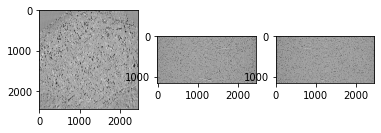

In [11]:
view_midplanes(Vrec_ubin)

In [19]:
Vx = normalize_volume_gpu(Vrec_ubin, chunk_size=1, use_autocontrast=True)
val = calc_SNR(Vx, Vseg_ubin, mask_ratio = 1)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

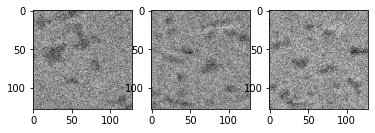

In [27]:
Va = Vx[1000:1128,1000:1128,1000:1128]
view_midplanes(Va+np.random.normal(0,0.4,Va.shape))

In [21]:
print(np.sum(Vseg_ubin==1))
print(np.sum(Vseg_ubin==0))

2098785384
4804809624


In [20]:
print(val)

nan


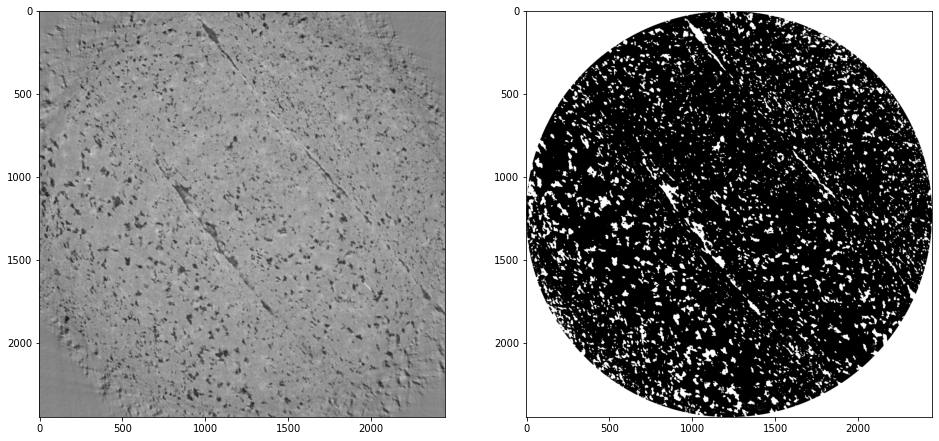

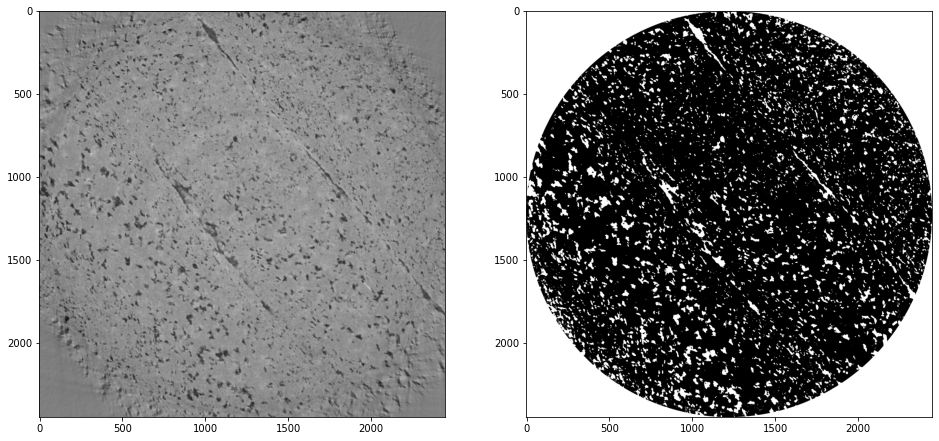

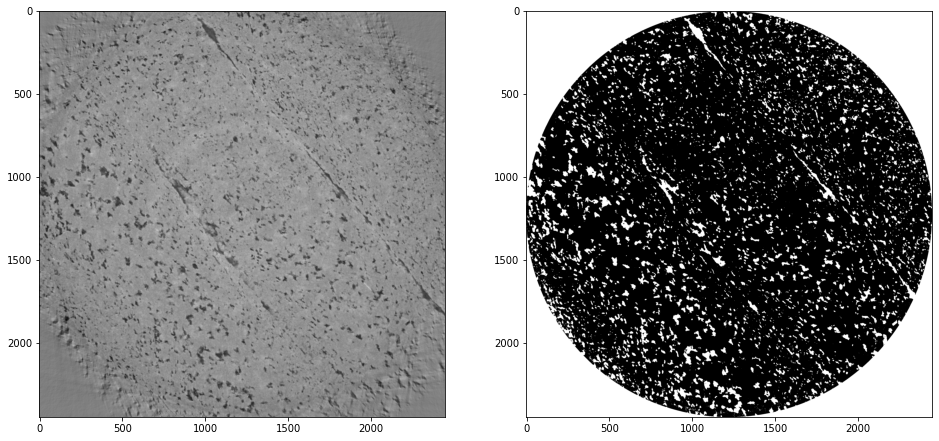

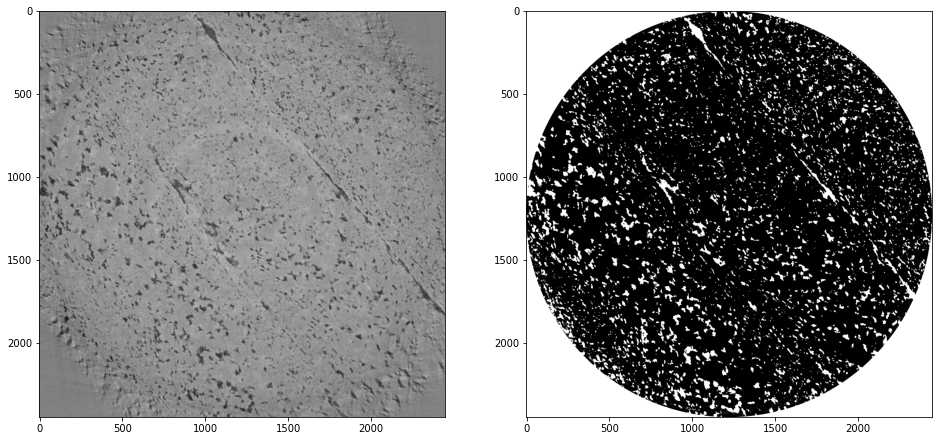

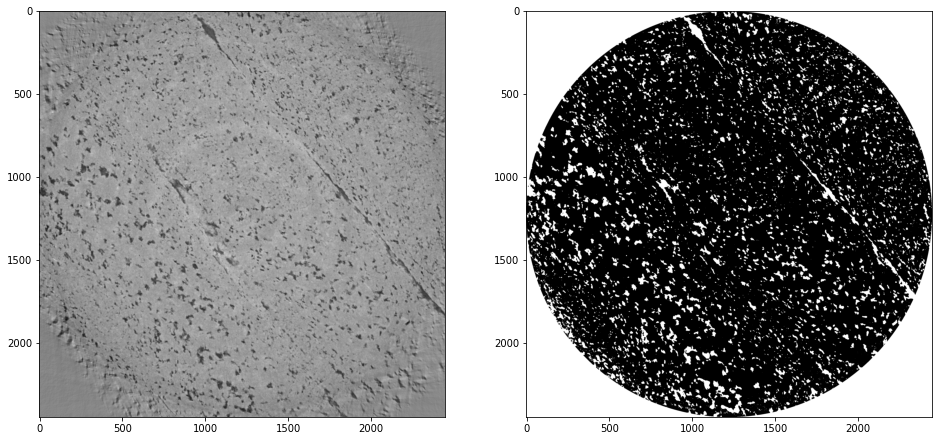

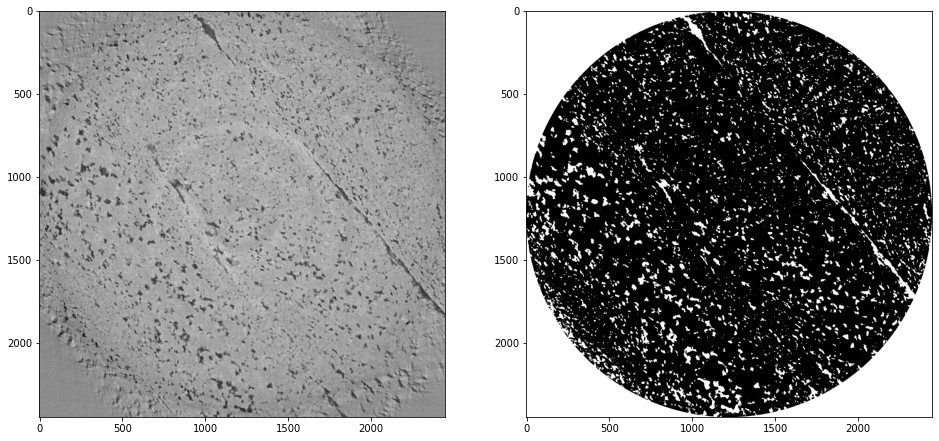

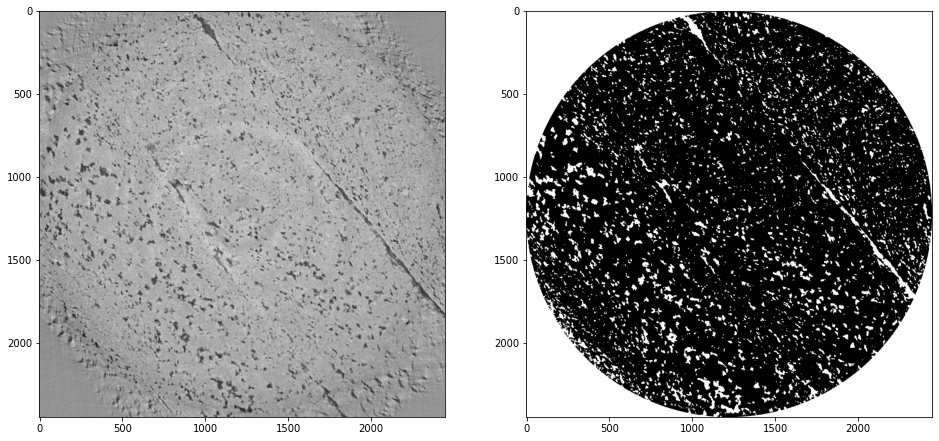

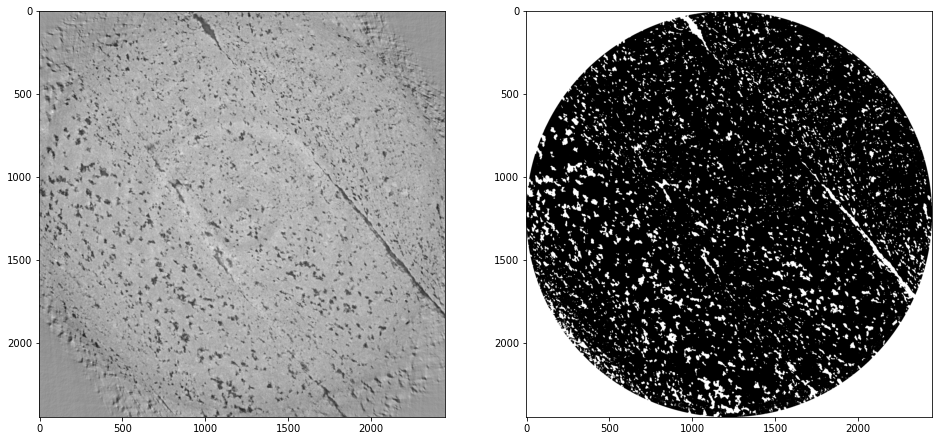

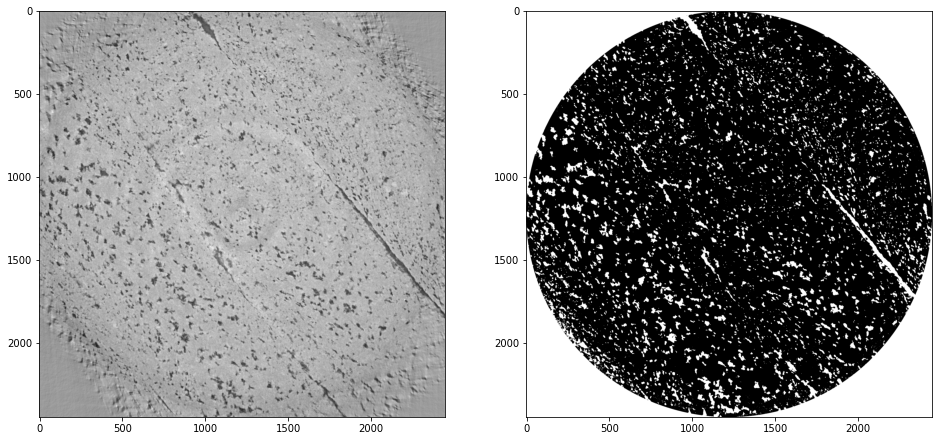

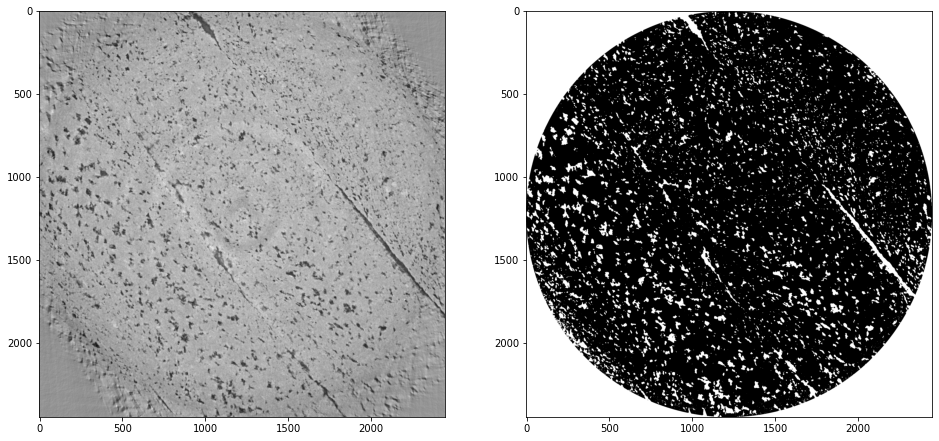

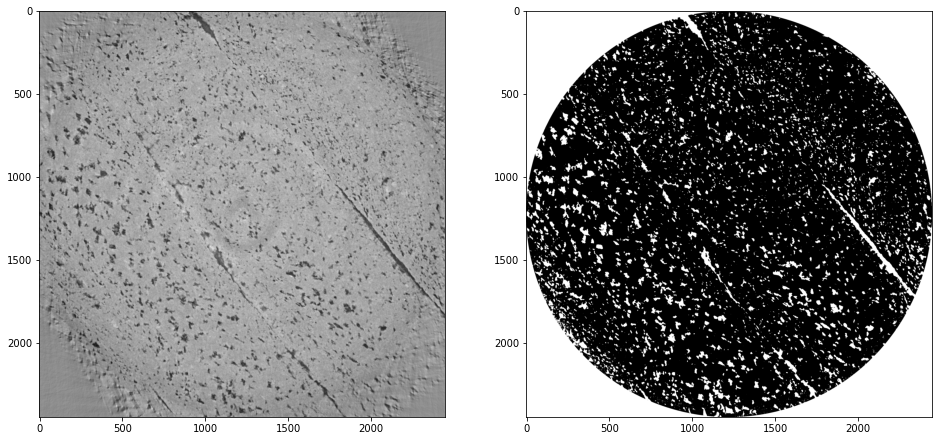

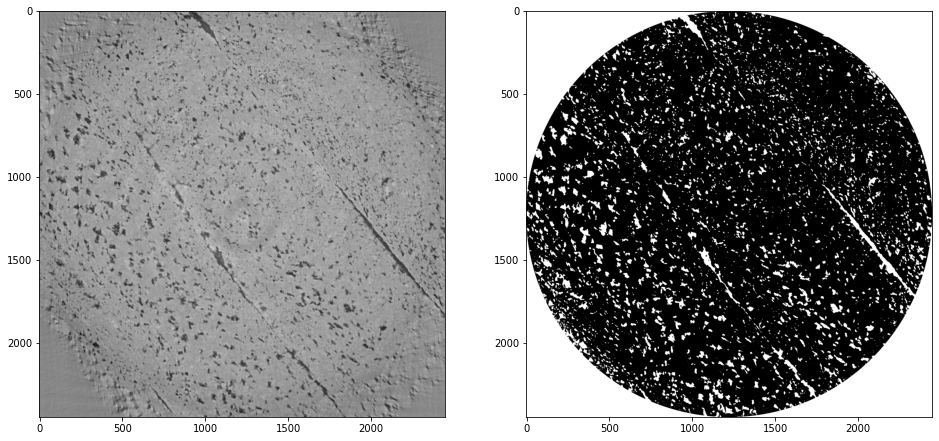

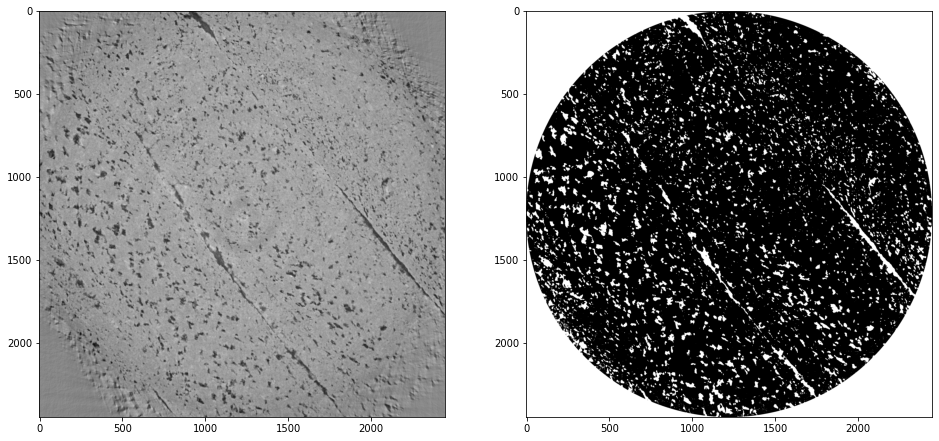

In [3]:
#Plot reconstructed slice
start = 100
stop = 112
for i in range(start, stop+1):
    fig, ax = plt.subplots(1,2, figsize = (16,16))
    ax[0].imshow(Vrec_ubin[i], cmap = 'gray')
    ax[1].imshow(Vseg_ubin[i], cmap = 'gray')
    plt.show()


In [4]:
s = slice(0,nz)
Vrec = np.array(Vrec_ubin[s])
Vseg = np.array(Vseg_ubin[s])

print(Vrec.shape)
print(Vseg.shape)

dfile = DataFile(f"/data01/Eaton_Polymer_AM/unet_data/test_data_rec_b{b}_sample{sample_tag}_layer{layer}", tiff = True, d_type = Vrec.dtype, d_shape = Vrec.shape)
dfile.create_new(overwrite=True)
dfile.write_full(Vrec)

dfile = DataFile(f"/data01/Eaton_Polymer_AM/unet_data/test_data_seg_b{b}_sample{sample_tag}_layer{layer}", tiff = True, d_type = Vseg.dtype, d_shape = Vseg.shape)
dfile.create_new(overwrite=True)
dfile.write_full(Vseg)


(1152, 2448, 2448)
(1152, 2448, 2448)
Removed old contents in tiff folder test_data_rec_b1_sample1_layer3
Removed old contents in tiff folder test_data_seg_b1_sample1_layer3
